### Use TCGA expression data to train RB1 signature

In [45]:
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression, SGDClassifier
from matplotlib import pyplot as plt

import helper

%matplotlib inline

### 1. TCGA expression data and RB1 mutation data preprocessing 

In [6]:
mRNA_file = "./data/TCGA/mRNA.tsv"
mutation_file = "./data/TCGA/RB1_maf.tsv"
clinical_file = "./data/TCGA/clinical.tsv"
copynumber_file = "./data/TCGA/RB1_copynumber.tsv"

In [46]:
mRNA_df = pd.read_csv(mRNA_file, delimiter="\t")
# dropna
mRNA_df.dropna(inplace=True)
# transpose
mRNA_df_transposed = mRNA_df.set_index("gene_id").transpose()
# take log
mRNA_df_transposed_log = mRNA_df_transposed.applymap(lambda x:np.log(x+1))

# save preprocessed mRNA (dropna, transpose, log)
mRNA_df_transposed_log.index.name = "sample_id"
# mRNA_df_transposed_log.to_csv("./data/TCGA/mRNA_transpose_log.csv")

# quantile normalization
mRNA_df_transposed_quantile = mRNA_df_transposed.rank(axis=1, pct=True)
mRNA_df_transposed_quantile.to_csv("./data/TCGA/mRNA_transpose_quantile.csv")

In [79]:
# get just prostate tissue
def get_label(barcode, dic):
    patient_id = barcode[:12]
    if patient_id in dic:
        return dic[patient_id]
    else:
        return None

    
for norm in ["quantile"]:
    mRNA_df = pd.read_csv("./data/TCGA/mRNA_transpose_{0}.csv".format(norm))
    clinical_df = pd.read_csv(clinical_file, delimiter="\t", 
                              encoding="ISO-8859-1", low_memory=False)
    tissue_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.acronym))
    label_df = pd.DataFrame(index=mRNA_df.sample_id)
    label_df["tissue"] = list(mRNA_df.sample_id.apply(lambda x: get_label(x, tissue_dict)))
    prostate_samples = list(label_df[label_df.tissue == "PRAD"].index)
    prostate_mRNA_df = mRNA_df[mRNA_df.sample_id.isin(prostate_samples)]
    prostate_mRNA_df.to_csv("./data/TCGA/mRNA_transpose_{0}_prostate.csv".format(norm), index=None)

In [246]:
# get RB1 mutation status from MAF file
def is_RB1_mutated(variant_classification):
    if variant_classification in ["Silent", "3'UTR", "Intron"]:
        return 0
    else:
        return 1
    
def add_to_label(barcode):
    if barcode[:15] not in RB1_dict.keys():
        return 0
    else:
        return RB1_dict[barcode[:15]]
    
    
rb_df = pd.read_csv(mutation_file, delimiter="\t")
rb_df["RB1_mutated"] = rb_df.Variant_Classification.apply(is_RB1_mutated)
RB1_dict = dict(zip([i[:15] for i in rb_df.Tumor_Sample_Barcode], 
                    rb_df.RB1_mutated))

assert(list(label_df.index) == list(mRNA_df.sample_id))
label_df["RB_mutated"] = list(map(add_to_label, list(label_df.index)))
label_df.RB_mutated.value_counts()

0    10684
1      385
Name: RB_mutated, dtype: int64

In [275]:
# get RB1 mutation from copy number file
def add_RB_cnv_info(barcode):
    sample_id = barcode[:15]
    if sample_id not in RB1_cnv_dict.keys():
        return 0
    else:
        copynumber = RB1_cnv_dict[sample_id]
        if copynumber == -2:
            return 1
        else: return 0

df_cnv = pd.read_csv(copynumber_file, delimiter="\t")
sample_cols = [i for i in df_cnv.columns if "TCGA" in i]
df_cnv = df_cnv[sample_cols]
RB1_cnv_dict = dict(zip([i[:15] for i in df_cnv.columns], df_cnv.iloc[0]))
label_df["RB_mutated1"] = list(map(add_RB_cnv_info, list(label_df.index)))
label_df.RB_mutated1.value_counts()

0    10769
1      300
Name: RB_mutated1, dtype: int64

In [283]:
label_df["rb_final"] = 0
label_df.loc[(label_df.RB_mutated==1)|(label_df.RB_mutated1==1), "rb_final"] = 1
label_df.rb_final.value_counts()

0    10404
1      665
Name: rb_final, dtype: int64

In [284]:
label_df[label_df.tissue=="PRAD"]["rb_final"].value_counts()

0    502
1     48
Name: rb_final, dtype: int64

In [285]:
label_df.to_csv("./data/TCGA/RB_labels.csv")

### 2. Training Signature with Logistic Regression (with L1 regularization)
#### 2.1 with just prostate sample

In [85]:
label_df = pd.read_csv("./data/TCGA/RB_labels.csv", index_col="sample_id")
X_prostate = pd.read_csv("./data/TCGA/mRNA_transpose_quantile_prostate.csv", index_col="sample_id")
y_prostate = label_df[label_df.tissue=="PRAD"].rb_final
assert(list(X_prostate.index) == list(y_prostate.index))

In [98]:
# stratified cross validation
# high regularization
# balance class weight with label frequency
classifiers = {"LR": LogisticRegression(penalty="l1", C=0.5, class_weight="balanced")}
X = X_prostate.as_matrix()
y = y_prostate.as_matrix()
result_df = helper.stratified_cv(X, y, classifiers["LR"], random_state=1)

1,2,3,4,5,6,7,8,9,10,

In [99]:
result_df

,1,2,3,4,5,6,7,8,9,10
train AUC,0.960089,0.952328,0.960177,0.959071,0.959071,0.954646,0.957965,0.960177,0.956858,0.961283
test AUC,0.750980,0.650980,0.820000,0.830000,0.770000,0.840000,0.740000,0.640000,0.805000,0.765000


In [100]:
result_df.mean(axis=1)

train AUC    0.958166
test AUC     0.761196
dtype: float64

In [101]:
clf = classifiers["LR"]
clf.fit(X, y)
gene_coef = clf.coef_[0]

In [102]:
TCGA_prostate_RB_signature_df = pd.DataFrame(index=X_prostate.columns, columns=None, data=gene_coef)

In [103]:
RBsig_prostate = pd.read_csv("./data/TCGA/RBsig_TCGA_prostate.csv", header=None)
RBsig_prostate[0] = RBsig_prostate[0].apply(lambda x:x.split("|")[0])
RBsig_prostate.to_csv("./data/TCGA/RBsig_TCGA_prostate.csv", header=None, index=None)

### 2. Training Signature with Logistic Regression (with L1 regularization)
#### 2.1 with all TCGA samples

In [104]:
label_df = pd.read_csv("./data/TCGA/RB_labels.csv", index_col="sample_id")
X = pd.read_csv("./data/TCGA/mRNA_transpose_quantile.csv", index_col="sample_id")

In [105]:
y = label_df.rb_final
assert(list(X.index) == list(y.index))
classifiers = {"LR": LogisticRegression(penalty="l1", C=0.1, class_weight="balanced", n_jobs=40)}
result_df = helper.stratified_cv(X.as_matrix(), y.as_matrix(), 
                                 classifiers["LR"], folds=5)

1,2,3,4,5,

In [106]:
result_df

,1,2,3,4,5
train AUC,0.937395,0.928855,0.924332,0.931576,0.932379
test AUC,0.823250,0.798857,0.830133,0.816848,0.851621


In [107]:
result_df.mean(axis=1)

train AUC    0.930908
test AUC     0.824142
dtype: float64

In [108]:
clf = classifiers["LR"]
clf.fit(X.as_matrix(), y.as_matrix())
gene_coef = clf.coef_[0]

In [109]:
TCGA_RB_signature_df = pd.DataFrame(index=X.columns, columns=None, 
                                    data=gene_coef)
TCGA_RB_signature_df.to_csv("./data/TCGA/RBsig_TCGA.csv", header=None)

In [110]:
RBsig_prostate = pd.read_csv("./data/TCGA/RBsig_TCGA.csv", header=None)
RBsig_prostate[0] = RBsig_prostate[0].apply(lambda x:x.split("|")[0])
RBsig_prostate.to_csv("./data/TCGA/RBsig_TCGA.csv", header=None, index=None)

### 3. Apply RB signatures to WCDT data

In [153]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
path_call = "./data/WCDT_final_path_call.csv"
WCDT_df = pd.read_csv(WCDT_mRNA, delimiter="\t", index_col="gene_id").T.rank(axis=1, pct=True)
path_call_df = pd.read_csv(path_call, index_col="Patient ID")

In [132]:
RBsig_prostate = pd.read_csv("./data/TCGA/RBsig_TCGA_prostate.csv", header=None)
RBsig_all = pd.read_csv("./data/TCGA/RBsig_TCGA.csv", header=None)
assert(list(RBsig_prostate[0])==list(RBsig_all[0]))

In [133]:
common_genes = sorted(list(set(RBsig_prostate[0]).intersection(set(WCDT_df.columns))))

In [134]:
WCDT_RBscore_prostate = np.dot(WCDT_df[common_genes].as_matrix(), 
                               RBsig_prostate.set_index(0).loc[common_genes].as_matrix())
WCDT_RBscore_all = np.dot(WCDT_df[common_genes].as_matrix(), 
                          RBsig_all.set_index(0).loc[common_genes].as_matrix())

In [135]:
RBscores = pd.DataFrame(index=WCDT_df.index)
RBscores["RBsig_prostate"] = WCDT_RBscore_prostate
RBscores["RBsig_all"] = WCDT_RBscore_all

In [161]:
RBscores = RBscores.loc[path_call_df.index]
RBscores

,RBsig_prostate,RBsig_all
Patient ID,,
DTB-001,-0.933912,-2.779784
DTB-002,-0.626456,-0.760286
DTB-003,-0.528911,3.257035
DTB-004,-0.563169,-3.133244
DTB-005,-0.812319,-0.656569
DTB-007,-0.548040,2.438527
DTB-008,-0.807594,-2.511162
DTB-009,-0.795575,2.017292
DTB-010Pro,-0.551169,-3.064181


In [185]:
path_call_df["Path Classification"].value_counts()

Not small cell    90
Small Cell        14
Unclassified       8
Mixed              7
Name: Path Classification, dtype: int64

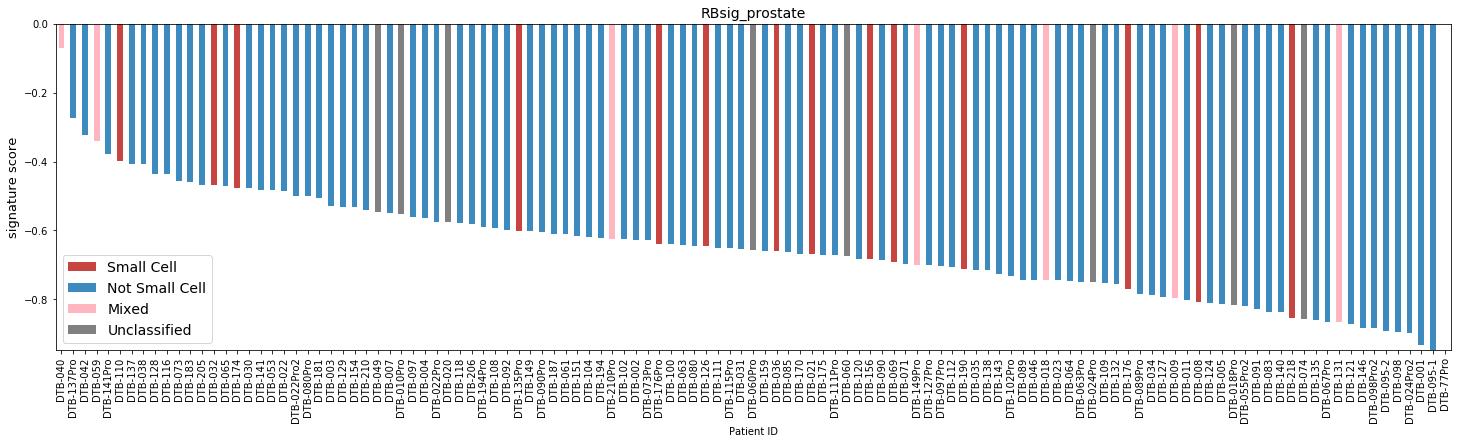

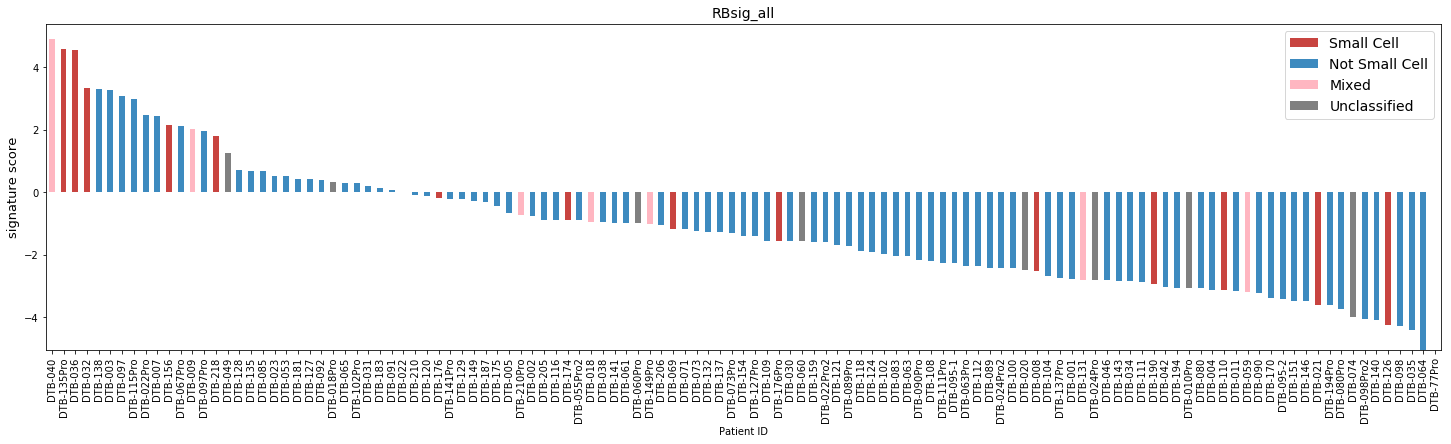

In [198]:
# apply NEPC signatures to known samples
assert(sorted(list(RBscores.index)) == sorted(list(path_call_df.index)))

for sig in RBscores.columns:
    RBscores.sort_values(sig, ascending=False, inplace=True)
    small_cell = list(path_call_df[path_call_df["Path Classification"] == "Small Cell"].index)
    mixed = list(path_call_df[path_call_df["Path Classification"] == "Mixed"].index)
    unclassified = list(path_call_df[path_call_df["Path Classification"] == "Unclassified"].index)
    not_small_cell = list(path_call_df[path_call_df["Path Classification"] == "Not small cell"].index)
    colors = dict(zip(small_cell + not_small_cell + mixed + unclassified, 
                      ["#C84440"] * len(small_cell) + ["#3D8ABF"] * len(not_small_cell) + 
                      ["#ffb6c1"] * len(mixed) + ["#808080"] * len(unclassified)))
    fig, ax= plt.subplots()
    fig.set_size_inches(25,6)
    RBscores[sig].plot.bar(ax=ax, color=[colors[i] for i in RBscores.index])
    ax.set_ylabel("signature score", fontsize=13)
    red_proxy = plt.Rectangle((0, 0), 1, 1, fc="#C84440")
    pink_proxy = plt.Rectangle((0, 0), 1, 1, fc="#3D8ABF")
    blue_proxy = plt.Rectangle((0, 0), 1, 1, fc="#ffb6c1")
    grey_proxy = plt.Rectangle((0, 0), 1, 1, fc="#808080")
    ax.legend([red_proxy,pink_proxy,blue_proxy,grey_proxy],
              ['Small Cell','Not Small Cell','Mixed','Unclassified'], fontsize=14)
    ax.set_title("{0}".format(sig), fontsize=14)
    fig.savefig("./{0}_scores.png".format(sig), dpi=200)